In [3]:
import time
import itertools
import numpy as np

import qiskit
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator

from qiskit.opflow import CircuitSampler

from qiskit.ignis.mitigation.measurement import CompleteMeasFitter # you will need to pip install qiskit-ignis
from qiskit.ignis.mitigation.measurement import complete_meas_cal

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
cmap = plt.get_cmap("plasma") #'viridis'

from modules.utils import *

from qae import *

import datetime

In [4]:
import tenpy
from tenpy.networks.mps import MPS
from tenpy.models.hubbard import BoseHubbardChain
from tenpy.algorithms import dmrg
from tenpy.linalg import np_conserved

def DMRG_EBH(L, V, t_list, chi_max=30, bc_MPS='infinite'):

    model_params = dict(n_max=1, filling=0.5, bc_MPS=bc_MPS, t=t_list,
                        L=L, V=V, mu=0, conserve='N')
    M = BoseHubbardChain(model_params)
        
    vector=[]
    for i in range(M.lat.N_sites):
        if i%2:
            vector.append(1)
        else:
            vector.append(0)

    psi = MPS.from_product_state(M.lat.mps_sites(), vector, bc=M.lat.bc_MPS)    
        
    dmrg_params = {                                                                                             
        'mixer': True,                                                                                          
        'trunc_params': {                                                                                       
        'chi_max': chi_max,                                                                                                                                                                    
        },                                                                                                      
        'max_E_err': 1.e-16,                                                                                    
        #'verbose': 0
    }
    
    info = dmrg.run(psi, M, dmrg_params)
    
    return info['E'], psi

In [5]:
print(qiskit.__version__, np.__version__, tenpy.__version__)

0.17.4 1.20.1 0.8.4


In [6]:
#IBMQ.load_account() # this then automatically loads your saved account
#provider = IBMQ.get_provider(hub='ibm-q-research')

In [7]:
#device = provider.backend.ibmq_rome # 6 bogota ; 4 rome

In [8]:
### Real device execution:
#backend = device 

### Simulation with noise profile from real device
#backend = qiskit.providers.aer.AerSimulator.from_backend(device)

### Simulation without noise
qiskit_chi = 100

backend = qiskit.providers.aer.AerSimulator(method="matrix_product_state",
                                            precision="single",
                                            matrix_product_state_max_bond_dimension = qiskit_chi,
                                            matrix_product_state_truncation_threshold = 1e-10,
                                            mps_sample_measure_algorithm = "mps_apply_measure", #alt: "mps_probabilities" 
                                           )

backend = qiskit.providers.aer.QasmSimulator(method="matrix_product_state",
                                            precision="single",
                                            matrix_product_state_max_bond_dimension = qiskit_chi,
                                            matrix_product_state_truncation_threshold = 1e-10,
                                            mps_sample_measure_algorithm = "mps_apply_measure", #alt: "mps_probabilities" 
                                           )
#backend = StatevectorSimulator()

In [9]:
### Preliminaries
L = 16
num_trash = int(np.log(L)/np.log(2))
anti = 1 # 1 for ferromagnetic Ising model, -1 for antiferromagnet

filename = "data/QAEAnsatz_scaling_MPS"

In [10]:
V = 1
deltat=1
chi = 100
print("bond dimension : ", chi)

bond dimension :  100


In [11]:
t_list = np.ones(L-1)
for i in range(len(t_list)):
    t_list[i] -= deltat*(-1)**i
E0, psi0 = DMRG_EBH(L, V, t_list, chi_max=chi, bc_MPS='finite')

/home/kkottmann/TeNPy/tenpy/algorithms/dmrg.py:1916: UserWarning: H is zero in the given block, nothing to diagonalize.We just return the initial state again.
  warnings.warn("H is zero in the given block, nothing to diagonalize."
/home/kkottmann/TeNPy/tenpy/tools/params.py:223: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [12]:
def qiskit_state(psi0):
    # G is only the local tensor (not multiplied by any singular values) - see https://tenpy.readthedocs.io/en/latest/reference/tenpy.networks.mps.html
    A_list = [psi0.get_B(i, form="G").to_ndarray().transpose([1,0,2]) for i in range(L)]
    for i,A in enumerate(A_list):
        A_list[i] = (A[0], A[1])
    S_list = [psi0.get_SR(i) for i in range(L-1)] # skip trivial last bond; hast to be of size L-1
    return (A_list, S_list)

Test state preparation

In [13]:
initcirc = QuantumCircuit(QuantumRegister(L,"q")) #,ClassicalRegister(num_trash, 'c'))
initcirc.set_matrix_product_state(qiskit_state(psi0))

qi = qiskit.utils.QuantumInstance(backend=backend, # , seed_simulator=seed, seed_transpiler=seed
                                  shots = 1000)

In [14]:
QZ = np.zeros(L)

In [80]:
for i in range(L):
    meas_outcome = ~StateFn(QNKron(L,Z,I,i)) @ StateFn(initcirc)
    QZ[i] = CircuitSampler(qi).convert(meas_outcome).eval()

<ipython-input-80-50c7739f7155>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  QZ[i] = CircuitSampler(qi).convert(meas_outcome).eval()


KeyboardInterrupt: 

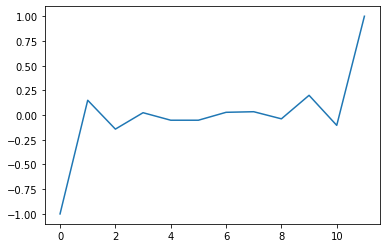

In [54]:
plt.plot(QZ)

should display the edge states for $V=1$ and $\delta t=1$

In [15]:
def prepare_circuit(thetas, L=6, num_trash=2, init_state=None, measurement=True,vqe=False):
    # QAE ansatz
    QAE_circ = QAEAnsatz(num_qubits = L, num_trash_qubits= num_trash, trash_qubits_idxs = list(range(num_trash)), measure_trash=measurement).assign_parameters(thetas)
    # initialize state vector
    initcirc = QuantumCircuit(QuantumRegister(L,"q"),ClassicalRegister(num_trash, 'c'))
    initcirc.set_matrix_product_state(qiskit_state(init_state))
    # compose circuits
    fullcirc = initcirc.compose(QAE_circ)
    return fullcirc

In [16]:
circ = prepare_circuit(thetas = np.random.rand(2*L+2), L = L, init_state = psi0)
#circ.draw("mpl")

In [17]:
### Execute circuit
count = 0
def run_circuit(thetas, L, num_trash, init_state, vqe=False, shots=100, meas_fitter = None):
    #global count
    #count += 1
    #print(count, "thetas: ", thetas)
    circ = prepare_circuit(thetas, L, num_trash, init_state, vqe=vqe)
    tcirc = qiskit.transpile(circ, backend)
    # Execute the circuit 
    job_sim = backend.run(tcirc, shots=shots) # , seed_simulator=123, seed_transpiler=234 fix seed to make it reproducible
    result = job_sim.result()
    # Results without mitigation
    counts = result.get_counts()
    if meas_fitter != None:
        # Get the filter object
        meas_filter = meas_fitter.filter

        # Results with mitigation
        mitigated_results = meas_filter.apply(result)
        counts = mitigated_results.get_counts(0)
    return counts

In [ ]:
t0 = time.time()
res = run_circuit(thetas = np.random.rand(num_trash*L+num_trash), L = L, num_trash = num_trash, init_state = psi0, shots=1000)
print("execution time: ", time.time()-t0)

In [61]:
res

{'010': 243,
 '111': 81,
 '000': 116,
 '011': 101,
 '101': 64,
 '001': 76,
 '110': 104,
 '100': 215}

In [62]:
def count_ones(string):
    return np.sum([int(_) for _ in string])

In [63]:
count_ones("01010111")

5

In [64]:
[_ for _ in res]

['010', '111', '000', '011', '101', '001', '110', '100']

In [65]:
[_ for _ in res if _ != "0" * num_trash]

['010', '111', '011', '101', '001', '110', '100']

In [66]:
np.sum([res[_]*count_ones(_) for _ in res if _ != "0" * num_trash]) # all measurement results except "000"

1315

In [67]:
### Optimize circuit
def cost_function_single(thetas, L, num_trash, init_state, shots=1000, vqe=True, param_encoding=False, x=0, meas_fitter=None):
    """ Optimizes circuit """
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots, meas_fitter=meas_fitter)
    cost = np.sum([out[_]*count_ones(_) for _ in out if _ != "0" * num_trash]) # all measurement results except "000"
    return cost/shots

def cost_function(thetas, L, num_trash, init_states, shots=1000, vqe=True, param_encoding=False, x=0, meas_fitter=None):
    """ Optimizes circuit """
    cost = 0.
    for init_state in init_states:
        cost += cost_function_single(thetas, L, num_trash, init_state, shots, vqe, param_encoding, meas_fitter=meas_fitter)
    return cost/len(init_states)

def optimize(init_states, L=6, num_trash=2, thetas=None, shots=1000, max_iter=400, vqe=True, param_encoding=False, x=0, pick_optimizer = None,
            meas_fitter=None):
    if thetas is None:
        n_params = (num_trash*L+num_trasg)*2 if param_encoding else (num_trash*L+num_trash)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    #print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, init_states, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    if pick_optimizer == "cobyla":
        optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    if pick_optimizer == "adam" or pick_optimizer == "ADAM":
        optimizer = qiskit.algorithms.optimizers.ADAM(maxiter=max_iter)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    if pick_optimizer == "spsa" or pick_optimizer == None:
        optimizer = SPSA(maxiter=max_iter,
                         #blocking=True,
                         callback=store_intermediate_result,
                         #learning_rate=0.3,
                         #perturbation=0.1
                         ) # recommended from qiskit (first iteraction takes quite long)
                           # to reduce time figure out optimal learning rate and perturbation in advance
    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, init_states, shots, vqe, param_encoding, x, meas_fitter=meas_fitter)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted



In [69]:
thetas_opt_mitigated, losses, accepted = optimize([psi0], max_iter=120, L=L, meas_fitter=None) #, pick_optimizer="adam")

Time: 55.33473 sec
(array([-0.11245148,  2.65757708,  1.24616617,  3.78211954,  5.29188688,
        1.37247104,  2.7129818 ,  7.80086283,  4.41320758,  6.92793833,
        5.66019167, -0.05908621,  0.09433427,  6.18455598,  3.81631703,
        4.37281042,  3.73378769, -2.09198213,  5.18541378,  3.99034717,
        0.30440508,  4.67170836,  3.25416314,  2.7151162 , -0.13577781,
        4.88093476]), 0.041, 360)


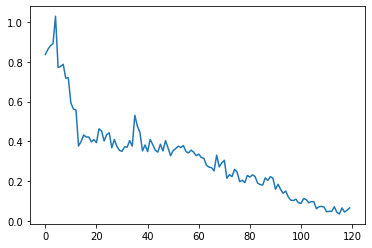

In [70]:
plt.plot(losses)

# Scaling

In [39]:
Ls = [3,4,8,16]
max_iter = [200,200,400,400]
num_trashs = np.log(Ls)/np.log(2)
num_trashs = np.array(num_trashs, dtype="int")
gz = 0
gx = 0.1

In [40]:
num_trashs

array([1, 2, 3, 4])

In [41]:
losses = [None] * len(Ls); accepted = [None] * len(Ls); thetas_opt= [None] * len(Ls)

3 1
Time: 8.67433 sec
(array([3.07648272, 1.56361937, 7.84589415, 2.361194  ]), 0.0, 600)


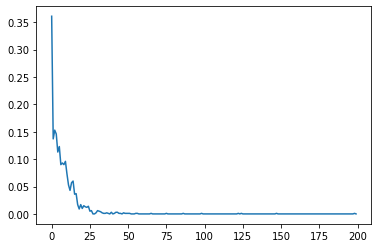

4 2
Time: 12.73539 sec
(array([ 2.3442365 , -0.04345353, -0.03793713,  4.61294707,  3.67121246,
        6.28585541,  4.02443093,  1.57918527,  0.15229448,  6.27960353]), 0.01, 600)


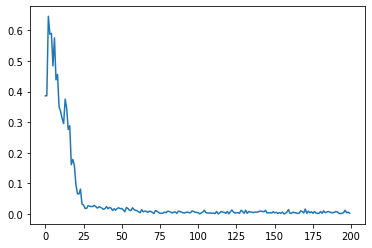

8 3
Time: 63.14955 sec
(array([-8.73995471e-02,  4.28642430e-01,  3.08963456e+00,  1.72460008e+00,
        3.09108557e+00,  4.55632362e+00,  2.71032603e+00,  2.98738136e+00,
        7.58566955e-01,  3.63867360e+00, -2.19903033e-03,  3.63819965e+00,
        3.31882223e+00,  4.62217747e+00,  3.11968164e+00,  4.48007029e+00,
        2.96187934e+00,  3.15432752e+00, -2.37261785e-03,  4.01989928e+00,
        3.32198260e+00,  4.25318712e+00,  4.40105377e+00,  4.42019076e+00,
        4.07115180e+00,  6.27286432e+00,  3.13756966e+00]), 0.0, 1200)


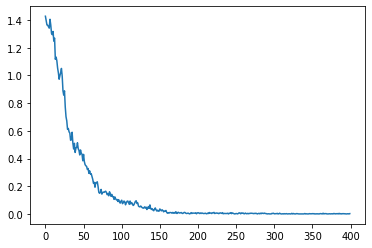

16 4
Time: 10225.27581 sec
(array([-1.28547780e-01, -4.67807808e-02, -2.61400062e+00,  3.09731224e+00,
        7.75768011e+00,  6.74988509e+00, -9.15197723e-02,  1.18656251e+00,
        5.91844255e+00,  3.28957200e+00,  6.22673195e+00,  4.67682022e+00,
        5.79295819e+00,  1.96932634e+00, -1.12183317e-02,  2.10824871e+00,
        5.13568517e+00,  5.31303712e-03,  5.93549409e-01,  6.26613758e+00,
        3.93897738e+00, -1.48762993e+00,  3.77539749e+00,  1.25623613e+00,
        5.98641915e-01,  1.85917876e+00,  5.17446139e+00,  4.72114956e+00,
       -1.19191781e-01, -1.08734214e+00,  4.45637388e+00,  2.21372673e+00,
        4.30854331e+00,  3.14114816e+00,  3.12761451e+00,  6.25810343e+00,
        2.13842256e+00,  6.37150739e+00,  4.41517194e+00,  8.00515968e-01,
        4.33496945e+00,  4.02361248e+00,  3.22237477e+00,  4.48781332e+00,
        3.25769028e+00,  1.94746671e+00,  1.31998000e+00,  4.72331553e+00,
        3.13469238e+00,  3.16279981e+00,  3.16650220e+00,  3.16020864e+0

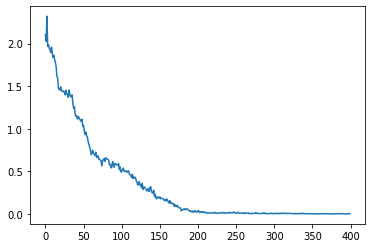

In [42]:
for j,(L,num_trash) in enumerate(zip(Ls,num_trashs)):
    print(L,num_trash)
    ED_state, ED_E, ham = ising_groundstate(L, anti, np.float32(gx), np.float32(gz))
    thetas_opt[j], losses[j], accepted[j] = optimize([ED_state], max_iter=max_iter[j], L=L, num_trash=num_trash, meas_fitter=None) #, pick_optimizer="adam")
    plt.plot(losses[j])
    plt.show()

In [43]:
np.savez(filename + "_losses", losses=losses, thetas_opt = thetas_opt, Ls=Ls, max_iter=max_iter, num_trashs=num_trashs)

/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [48]:
temp = np.load(filename + "_losses.npz", allow_pickle=True)
losses0 = temp["losses"]

In [49]:
min_losses = [np.min(l) for l in losses0]

In [50]:
min_losses

[0.0, 0.0, 0.0, 0.0]

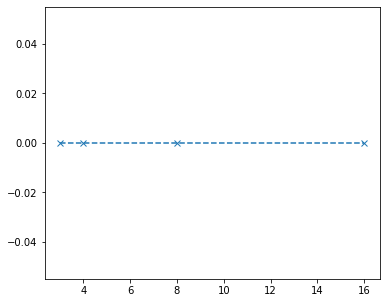

In [51]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(Ls, min_losses,"x--")
#ax.set_yscale("log")
#ax.set_xscale("log")

In [142]:
gxs = np.linspace(0,2,10)
L = 10
Smag = []
for gx in gxs:
    ED_state, ED_E, ham = ising_groundstate(L, anti, np.float32(gx), np.float32(gz))
    Sen = ED_E
    Smag.append(ED_state.T.conj()@Mag(L,anti)@ED_state)
    

/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


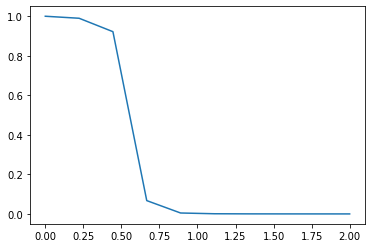

In [143]:
plt.plot(gxs, Smag)